# B2B Discount Optimization

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Reading the data
url = "https://raw.githubusercontent.com/ormarketing/b2b/master/data.csv"
data = pd.read_csv(url)
data.to_csv('data.csv')

In [4]:
#Let's see the data first 
data

,ID,Close Date,Created Date,New Logo,Type,Stage,Billing Plan,ACV,Discount Amount,Amount,Net Amount
0,1,5/26/17,5/4/17,1,Direct - Cloud Product,Closed Lost,3 Years,431370,,225000,225000
1,2,12/29/16,11/29/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,22050,80850,147000,66150
2,3,12/29/16,12/9/16,1,Partner - Cloud Product,Closed Won - Paid,3 Years,32750,43200,96000,52800
3,4,9/9/16,4/20/16,1,Direct - Cloud Product,Closed Won - Paid,4 Years,36694,44800,128000,83200
4,5,9/22/16,9/1/16,1,Partner - OnPremise Product,Closed Won - Paid,3 Years,18700,9900,66000,56100
...,...,...,...,...,...,...,...,...,...,...,...
1500,1501,2/4/16,9/17/15,0,Direct - OnPremise Product,Closed Lost,NaN,17900,NaN,17900,17900
1501,1502,10/4/16,2/5/16,0,Partner - OnPremise Product,Closed Lost,NaN,60000,NaN,60000,60000
1502,1503,11/4/16,9/21/16,0,Direct - OnPremise Product,Closed Lost,Annual,55000,20000,75000,55000
1503,1504,9/6/17,5/24/17,1,Direct - OnPremise Product,Closed Lost,NaN,32000,NaN,32000,32000


In [5]:
#Check for null values
data.isnull().sum()

ID                     0
Close Date             0
Created Date           0
New Logo               0
Type                   0
Stage                  0
Billing Plan         525
 ACV                  33
 Discount Amount     837
 Amount                0
 Net Amount            0
dtype: int64

### Exploratory Data Analysis 

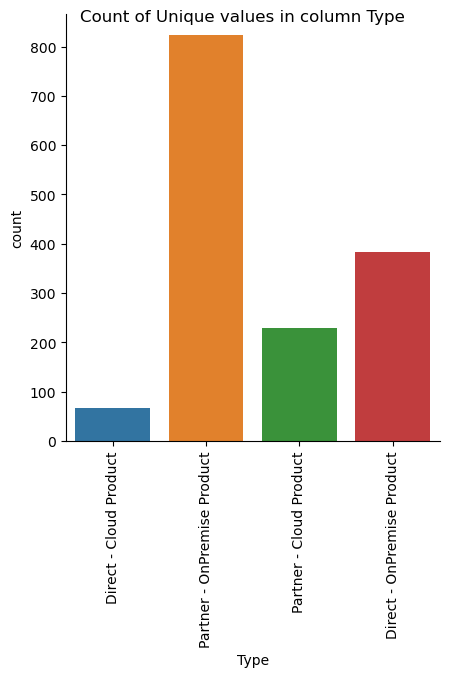

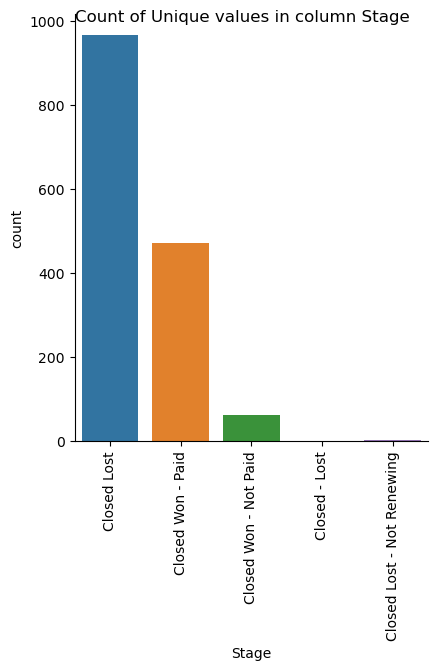

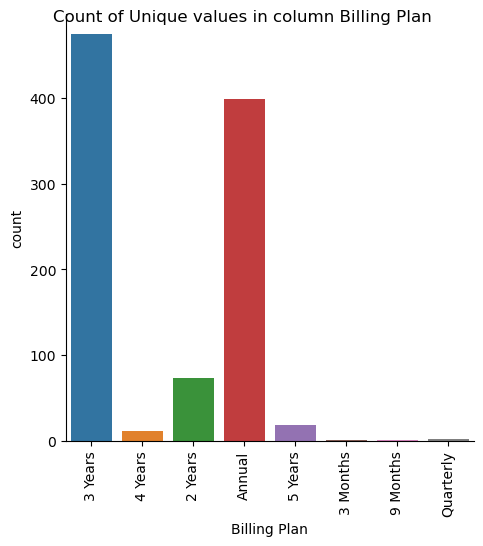

In [6]:
# Count of unique values in categorical columns 
cols = ['Type','Stage','Billing Plan']

for col in cols:
    plot=sns.catplot(data=data,x=col,kind='count')
    plot.set_xticklabels(rotation=90) 
    plot.fig.suptitle(f"Count of Unique values in column {col} ")
    plt.show()

In [7]:
#Removing leading and trailing white spaces in the column names
data.columns = data.columns.str.strip()

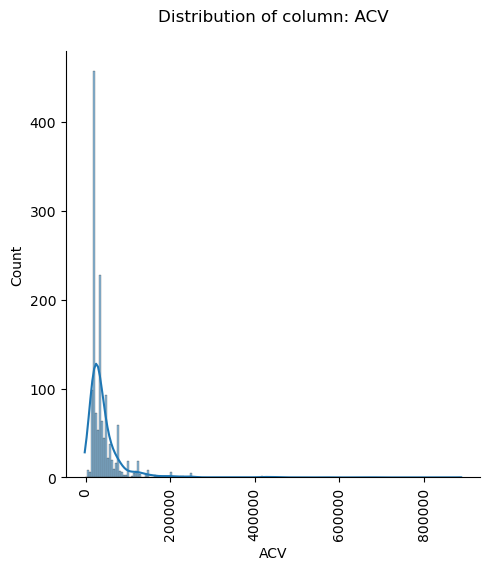

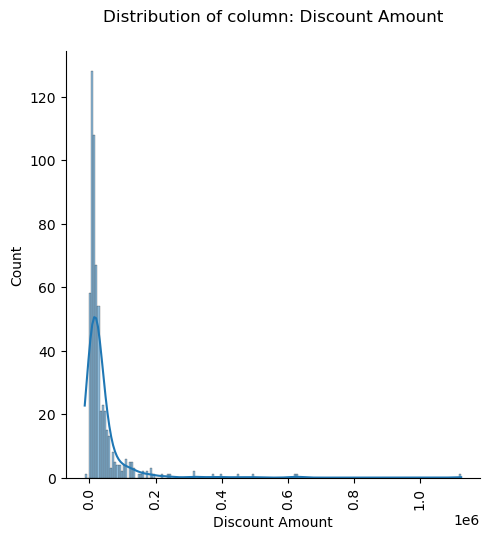

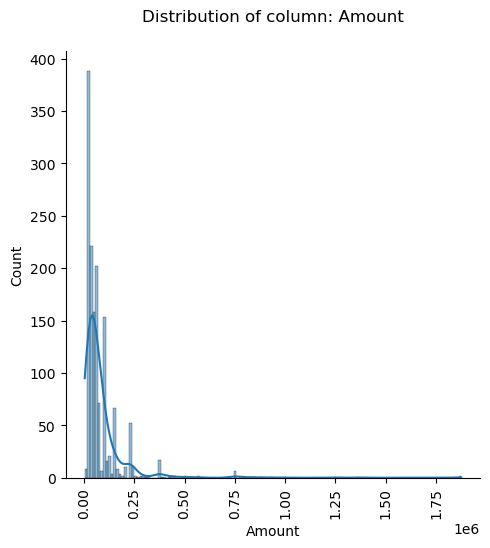

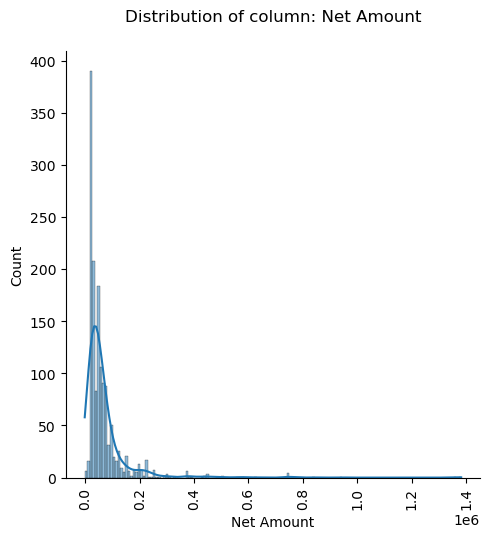

In [8]:
#Distribution of numeric columns 

num_cols = ['ACV', 'Discount Amount', 'Amount', 'Net Amount']

for col in num_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

for col in num_cols:
    plot = sns.displot(data, x=col,kde="false")
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.title(f"Distribution of column: {col}", y=1.05)  # Set the title for the plot
    plt.show()


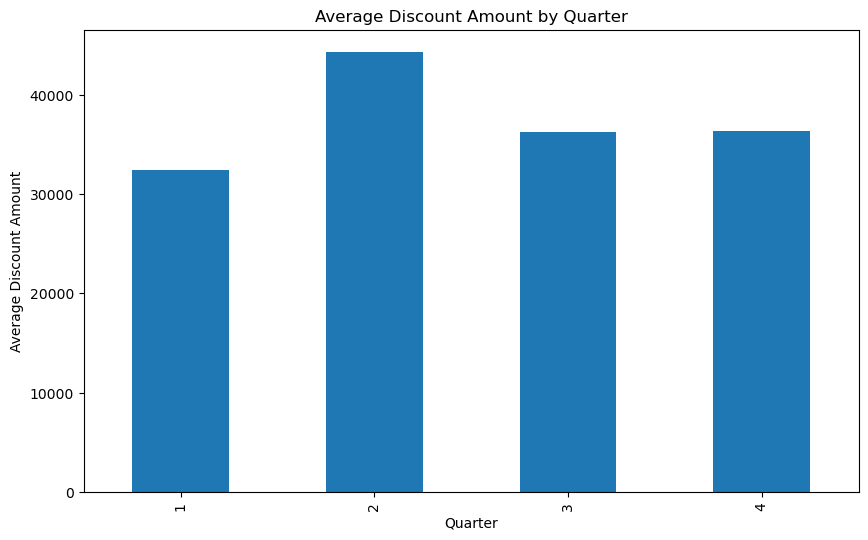

In [11]:
#Create a new quarter column
data['Close Date'] = pd.to_datetime(data['Close Date'])
data['quarter'] = data['Close Date'].dt.quarter

# Plot time series visualization for discounts in each quarter
discounts_by_quarter = data.groupby('quarter')['Discount Amount'].mean()

plt.figure(figsize=(10, 6))
discounts_by_quarter.plot(kind='bar')
plt.title('Average Discount Amount by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Discount Amount')
plt.show()

In [25]:
#Let us create our logit model first 

# Create the target variable: 1 if 'Stage' indicates a won deal, 0 otherwise
data['won'] = data['Stage'].apply(lambda x: 1 if 'Closed Won' in x else 0)

# Identify features and target variable
features = ["Discount Amount", "Amount", "quarter", "New Logo", "Type", "Billing Plan"]
target = "won"

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first')
encoded_features = encoder.fit_transform(data[['New Logo', 'Type', 'Billing Plan']]).toarray()
encoded_feature_names = encoder.get_feature_names_out(['New Logo', 'Type', 'Billing Plan'])
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate encoded features with the rest of the data
data = pd.concat([data, encoded_df], axis=1)

# Updated features list after encoding
encoded_features_list = ["Discount Amount", "Amount", "quarter"] + list(encoded_feature_names)
X = data[encoded_features_list]
y = data[target]

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the dataset into training and hold-out samples
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

# Estimate logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate model performance on holdout data
y_pred_proba = model.predict_proba(X_holdout)[:, 1]
log_loss_score = log_loss(y_holdout, y_pred_proba)
accuracy = accuracy_score(y_holdout, model.predict(X_holdout))

print(f"Log Loss: {log_loss_score}")
print(f"Accuracy: {accuracy}")


Log Loss: 0.6319812394314834
Accuracy: 0.7142857142857143


In [45]:
# Function to optimize discounts
def optimize_discount(X, model, discount_col_index):
    X_optimized = X.copy()
    for i in range(X.shape[0]):
        best_discount = 0
        best_prob = 0
        for d in np.arange(0, 1.01, 0.01):
            row = np.array(X[i, :discount_col_index].tolist() + [d] + X[i, discount_col_index+1:].tolist())
            prob = model.predict_proba([row])[0, 1]
            if prob > best_prob:
                best_prob = prob
                best_discount = d
        X_optimized[i, discount_col_index] = best_discount
    return X_optimized

# Find the column index for the discount column
discount_col_index = encoded_features_list.index("Discount Amount")
# Optimize discounts for the holdout sample
X_holdout_optimized = optimize_discount(X_holdout, model, discount_col_index)

# Function to calculate expected revenue
def expected_revenue(data, discount_col_index, amount_col_index, model):
    total_revenue = 0
    for i in range(data.shape[0]):
        row = np.array(data[i, :discount_col_index].tolist() + [data[i, discount_col_index]] + data[i, discount_col_index+1:].tolist())
        # *** Predict if the deal will be won or not based on the other features ***
        prob = model.predict_proba([row])[0, 1]
        # *** #Calculate the revenue  ***
        revenue = (data[i, amount_col_index] - data[i, discount_col_index]) * prob
        total_revenue += revenue
    return total_revenue

# Find the column index for the amount column
amount_col_index = encoded_features_list.index("Amount")
# Calculate actual and optimized expected revenue
actual_revenue = expected_revenue(X_holdout, discount_col_index, amount_col_index, model)
optimized_revenue = expected_revenue(X_holdout_optimized, discount_col_index, amount_col_index, model)

# Calculate revenue improvement
revenue_improvement = optimized_revenue - actual_revenue

# Print the results
print(f"The Actual Revenue before Optimized Disounts for the holdout data: ${round(actual_revenue,0)}")
print(f"The Revenue after Optimized Discounts for the holdout data: ${round(optimized_revenue,0)}")
print(f"The Revenue Improvement for the holdout data: ${round(revenue_improvement,0)}")

The Actual Revenue before Optimized Disounts for the holdout data: $6681861.0
The Revenue after Optimized Discounts for the holdout data: $15421754.0
The Revenue Improvement for the holdout data: $8739893.0
